In [12]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from timm import create_model
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from itertools import cycle
import numpy as np
from numpy import interp  # Replacing scipy interp with numpy's interp


In [13]:
# Set the directory where the lung CT scan images for COVID-19 are stored
data_dir = 'C:/Users/Hello/OneDrive/Desktop/project/covid data'

# Define a series of transformations to preprocess the images:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to 224x224 pixels
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flipping to augment data
    transforms.RandomRotation(10),  # Rotate images randomly by up to 10 degrees for augmentation
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the images using predefined mean and standard deviation
])

# Create a dataset by loading images from the specified directory and applying the transformations
dataset = ImageFolder(data_dir, transform=transform)

# Splitting the dataset into training, validation, and testing sets:
train_size = int(0.8 * len(dataset))  # 80% of data for training
val_size = int(0.1 * len(dataset))  # 10% of data for validation
test_size = len(dataset) - train_size - val_size  # Remaining 10% for testing
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])  # Perform the actual split

# Create data loaders for each set (train, validation, test) to enable batch processing and shuffling:
batch_size = 32  # Number of images processed in each batch
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Training loader with shuffling
val_loader = DataLoader(val_dataset, batch_size=batch_size)  # Validation loader without shuffling
test_loader = DataLoader(test_dataset, batch_size=batch_size)  # Test loader without shuffling


In [14]:
# Load the pre-trained EfficientNetB1 model with custom settings
model = create_model("efficientnet_b1", pretrained=True, num_classes=len(dataset.classes))
# 'pretrained=True' loads a model pre-trained on ImageNet
# 'num_classes=len(dataset.classes)' sets the number of output classes based on the dataset

# Define the loss function and the optimizer for training:
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss is commonly used for classification tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with a learning rate of 0.001

# Set up the device (GPU or CPU) for training:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 'torch.device' selects 'cuda' if a GPU with CUDA is available, otherwise defaults to CPU
model.to(device)  # Move the model to the specified device (GPU or CPU) for computation efficiency
print('done')


done


In [15]:
import time
import torch
from tqdm import tqdm
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Number of epochs and early stopping patience
num_epochs = 10  
patience = 3  

# Model complexity reduction (simplified architecture example)
class SimplifiedCNN(nn.Module):
    def __init__(self):
        super(SimplifiedCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  # Simplified fully connected layer
        self.dropout = nn.Dropout(0.5)  # Dropout to prevent overfitting
        self.fc2 = nn.Linear(128, 2)  # Binary classification (COVID, Non-COVID)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Dropout
        x = self.fc2(x)
        return x

# Class weights for handling imbalance
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = torch.tensor([1., 7.], device=device)  # Adjust based on dataset

# Initialize the model
model = SimplifiedCNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)  # Use class weighting for imbalance
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # L2 regularization

# Training and validation data loaders with reduced batch size
batch_size = 16  # Reduced batch size for faster training
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Early stopping and metrics tracking
best_val_loss = float("inf")
no_improve_epochs = 0

metrics = {
    "Epoch": [],
    "Training Loss": [],
    "Training Accuracy": [],
    "Validation Loss": [],
    "Validation Accuracy": []
}

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    # Loop over each batch in the training set
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total

    # Validation loop
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            
            val_running_loss += val_loss.item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    # Print metrics after each epoch
    print(f'\nEpoch {epoch + 1}/{num_epochs} - '
          f'Train Loss: {train_loss:.4f} - '
          f'Train Accuracy: {train_accuracy:.2f}% - '
          f'Validation Loss: {val_loss:.4f} - '
          f'Validation Accuracy: {val_accuracy:.2f}%')

    # Store metrics for this epoch
    metrics["Epoch"].append(epoch + 1)
    metrics["Training Loss"].append(train_loss)
    metrics["Training Accuracy"].append(train_accuracy)
    metrics["Validation Loss"].append(val_loss)
    metrics["Validation Accuracy"].append(val_accuracy)

    # Early stopping based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print("\nEarly stopping triggered.")
            break

# Convert metrics to DataFrame for tabular representation
metrics_df = pd.DataFrame(metrics)
print(metrics_df)



Epoch 1/10 - Train Loss: 0.5505 - Train Accuracy: 72.93% - Validation Loss: 0.0925 - Validation Accuracy: 91.24%



Epoch 2/10 - Train Loss: 0.0894 - Train Accuracy: 90.64% - Validation Loss: 0.0757 - Validation Accuracy: 90.21%



Epoch 3/10 - Train Loss: 0.0722 - Train Accuracy: 92.62% - Validation Loss: 0.0682 - Validation Accuracy: 91.75%



Epoch 4/10 - Train Loss: 0.0493 - Train Accuracy: 94.10% - Validation Loss: 0.0713 - Validation Accuracy: 95.36%



Epoch 5/10 - Train Loss: 0.0479 - Train Accuracy: 94.29% - Validation Loss: 0.0644 - Validation Accuracy: 96.91%



Epoch 6/10 - Train Loss: 0.0375 - Train Accuracy: 95.64% - Validation Loss: 0.0585 - Validation Accuracy: 91.24%



Epoch 7/10 - Train Loss: 0.0346 - Train Accuracy: 96.60% - Validation Loss: 0.0578 - Validation Accuracy: 96.39%



Epoch 8/10 - Train Loss: 0.0293 - Train Accuracy: 97.24% - Validation Loss: 0.0324 - Validation Accuracy: 95.88%



Epoch 9/10 - Train Loss: 0.0407 - Train Accuracy: 95.96% - Validation Loss: 0.0888 - Validation Accuracy: 96.39%



Epoch 10/10 - Train Loss: 0.0192 - Train Accuracy: 98.65% - Validation Loss: 0.0400 - Validation Accuracy: 98.45%
   Epoch  Training Loss  Training Accuracy  Validation Loss  \
0      1       0.550482          72.931366         0.092543   
1      2       0.089390          90.635022         0.075725   
2      3       0.072175          92.623477         0.068215   
3      4       0.049255          94.098781         0.071300   
4      5       0.047915          94.291212         0.064392   
5      6       0.037467          95.638230         0.058500   
6      7       0.034611          96.600385         0.057783   
7      8       0.029276          97.241822         0.032447   
8      9       0.040654          95.958948         0.088772   
9     10       0.019167          98.652983         0.040027   

   Validation Accuracy  
0            91.237113  
1            90.206186  
2            91.752577  
3            95.360825  
4            96.907216  
5            91.237113  
6            96.

Test accuracy: 97.96%


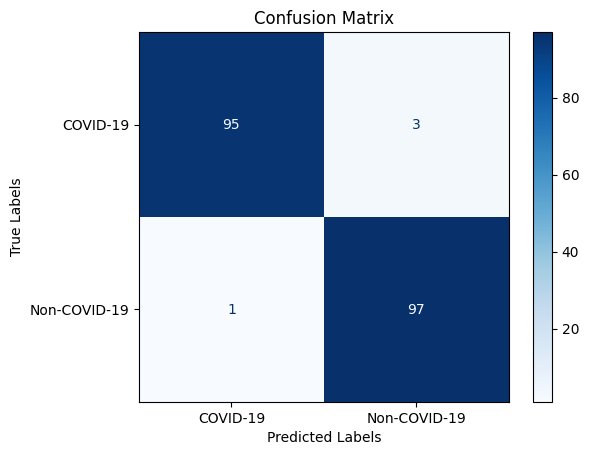

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Test accuracy: {accuracy * 100:.2f}%")

# Access 'classes' from the original dataset
num_classes = len(dataset.classes)

# Create a confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions, labels=range(num_classes))

# Visualize the confusion matrix
class_names = dataset.classes
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format="d")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


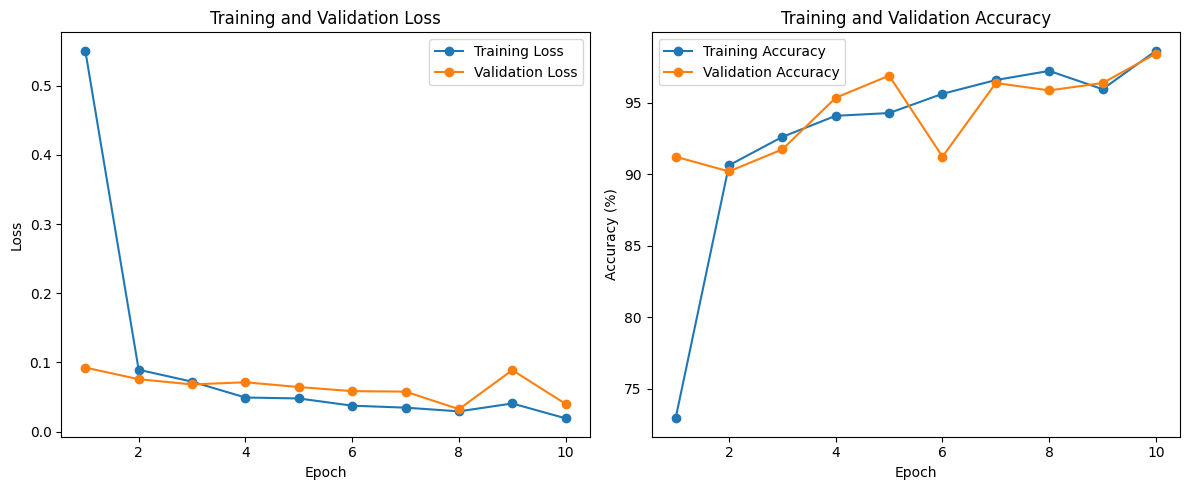

In [17]:
import matplotlib.pyplot as plt

# Extract metrics from the DataFrame
epochs = metrics_df["Epoch"]
train_loss = metrics_df["Training Loss"]
train_accuracy = metrics_df["Training Accuracy"]
val_loss = metrics_df["Validation Loss"]
val_accuracy = metrics_df["Validation Accuracy"]

# Plotting training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Training Loss", marker='o')
plt.plot(epochs, val_loss, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label="Training Accuracy", marker='o')
plt.plot(epochs, val_accuracy, label="Validation Accuracy", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


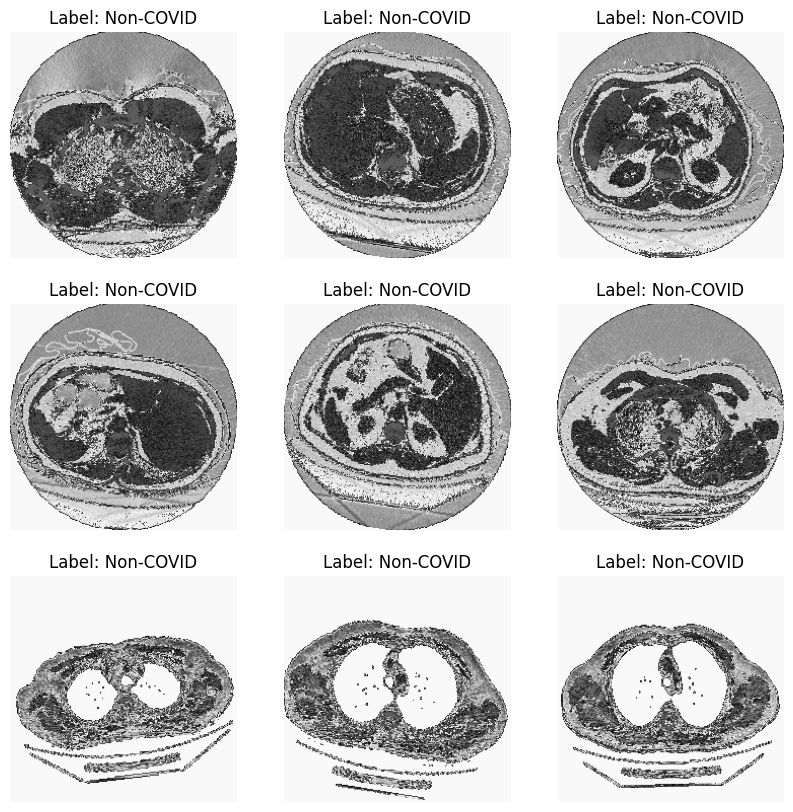

In [18]:
def visualize_dataset(dataset):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        image, label = dataset[i]
        image = transforms.ToPILImage()(image).convert("L")  # Convert to grayscale
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {'COVID' if label == 1 else 'Non-COVID'}")
        plt.axis('off')
    plt.show()

# Visualizing the first 9 grayscale images from the dataset
visualize_dataset(dataset)

In [19]:
import matplotlib.pyplot as plt

# Assuming 'model' is the name of your trained model
model.eval()

# Get predictions for the training set
all_labels_train = []
all_predictions_train = []

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_labels_train.extend(labels.cpu().numpy())
        all_predictions_train.extend(predicted.cpu().numpy())

# Convert predictions to NumPy array
all_predictions_train = np.array(all_predictions_train)




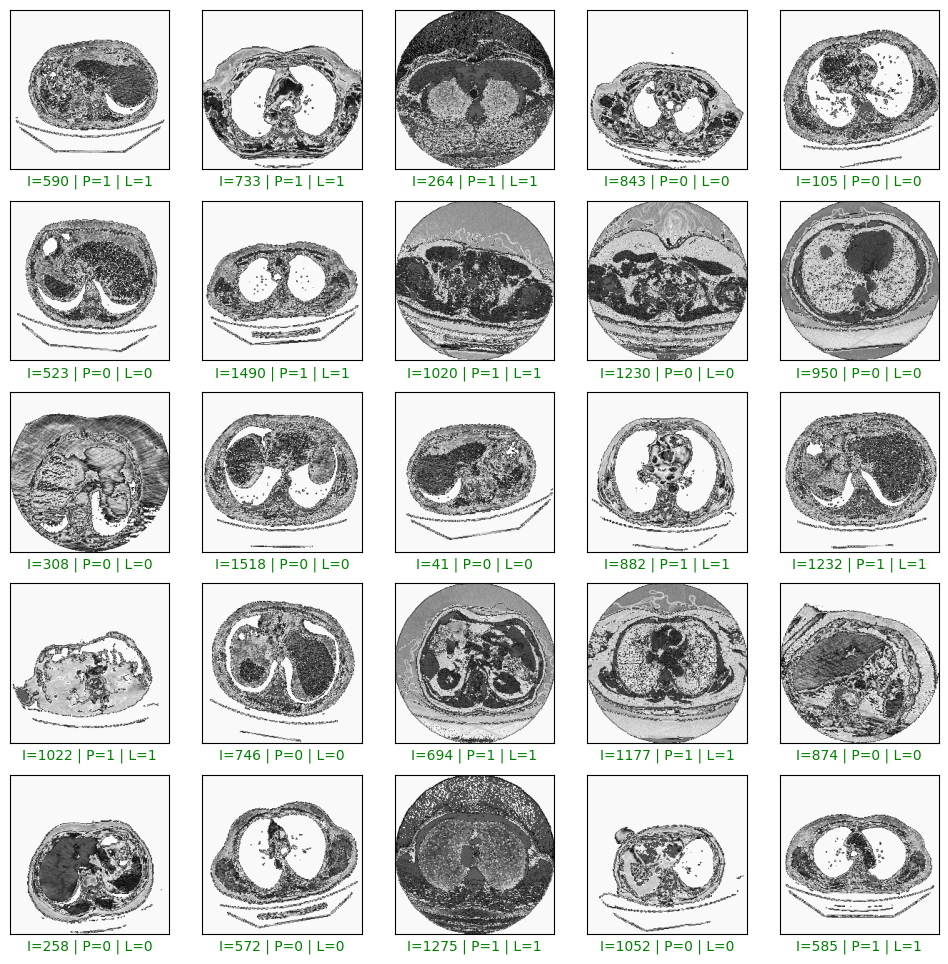

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

# Assuming 'train_dataset' is a PyTorch dataset
# Make sure to replace this line with your actual dataset import and instantiation

# Randomly choose a subset of predictions for visualization
plt.figure(figsize=(12, 12))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    R = np.random.choice(len(all_predictions_train))
    pred = all_predictions_train[R]
    actual = all_labels_train[R]
    col = 'g' if pred == actual else 'r'
    
    image, _ = train_dataset[R]
    image = image.numpy().transpose(1, 2, 0)  # Assuming the image is in the format (channels, height, width)
    
    # Convert image to uint8 format before transforming to grayscale
    image_uint8 = (image * 255).astype(np.uint8)
    
    image_gray = transforms.ToPILImage()(image_uint8).convert("L")  # Convert to grayscale
    plt.imshow(image_gray, cmap='gray')
    
    plt.xlabel('I={} | P={} | L={}'.format(R, pred, actual), color=col)

plt.show()


In [21]:
# After the training loop (after the model has been trained)
torch.save(model.state_dict(), 'covid-bin.pth')


In [22]:
# Create a new instance of your model
model = SimplifiedCNN()

# Load the saved state dict into the model
model.load_state_dict(torch.load('covid-bin.pth'))

# Set the model to evaluation mode if necessary
model.eval()


C:\Users\Hello\AppData\Local\Temp\ipykernel_13540\7750070.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('covid-bin.pth'))


SimplifiedCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)